In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import sys
from tensorflow.python.client import device_lib
import os

os.environ["CUDA_VISIBLE_DEVICES"]="2"

# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[1],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[2],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[3],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Virtual devices must be set before GPUs have been initialized
#         print(e)

2023-09-12 13:19:52.386866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Data

In [2]:
import os

directory = os.fsencode( "../../../../../datax/scratch/pma/reverse_search/train/")
count = 0
top = 20
data = []
for folder in os.listdir(directory):
    print(folder)
    for subfolder in os.listdir(directory+folder):
        back = os.fsencode( "/")
        for file in os.listdir(directory+folder+back+subfolder):
            file_directory = str(os.path.join(directory+folder+back+subfolder, file)).replace('b', '').replace("'","")
            if 'filtered.npy' in file_directory and count < top:
                temp = np.load(str(file_directory))
                print(temp.shape)
                data.append(temp)
                count += 1

b'HIP44295-23'
(59130, 16, 256)
(75785, 16, 256)
(72628, 16, 256)
(46460, 16, 256)
(82200, 16, 256)
(45100, 16, 256)
b'HIP63503-523'
(6872, 16, 256)
(4116, 16, 256)
(2969, 16, 256)
(8655, 16, 256)
(5428, 16, 256)
(5618, 16, 256)
b'AND_XI-2274'
b'HIP36393-1253'
(17834, 16, 256)
(19223, 16, 256)
(20366, 16, 256)
(29689, 16, 256)
(16113, 16, 256)
(13838, 16, 256)
b'HIP48477-589'
(15476, 16, 256)
(33786, 16, 256)


(581286, 16, 256)


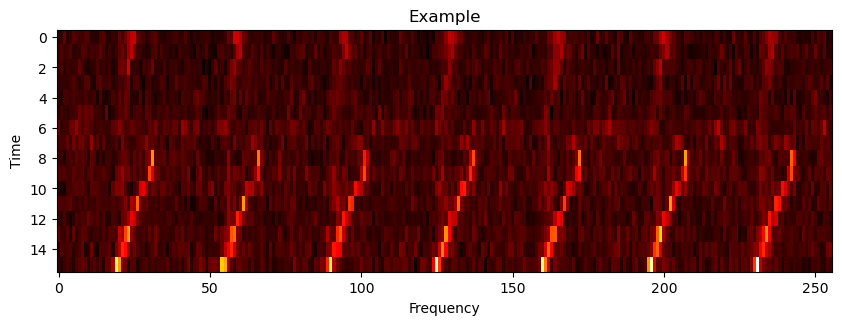

In [3]:
import numpy as np
data = np.vstack(data)
print(data.shape)

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(10,5))
plt.title("Example")
plt.xlabel("Frequency")
plt.ylabel("Time")
plt.imshow(data[1000, :, :], cmap='hot', aspect=5)

In [4]:
from tqdm import tqdm

def normalize(data):
    epsilon = 1
    min_val = data.min()
    data = data - min_val + epsilon
    new_data = np.log(data)
    min_val = data.min()
    max_val = data.max()
    final_data = (data - min_val) / (max_val - min_val)
    return final_data
    
def normalize_data(data):
    for i in tqdm(range(data.shape[0])):
        data[i,:,:] = normalize(data[i,:,:])
    return data

data = np.expand_dims(normalize_data(data), axis = -1)
print(data[0,:,:].max(), data[0,:,:].min())

100%|████████████████████████████████| 581286/581286 [00:53<00:00, 10879.07it/s]

1.0 0.0


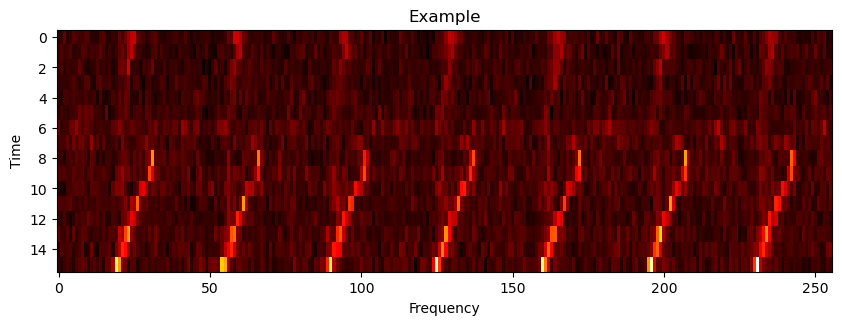

In [5]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(10,5))
plt.title("Example")
plt.xlabel("Frequency")
plt.ylabel("Time")
plt.imshow(data[1000, :, :], cmap='hot', aspect=5)

In [6]:
from sklearn.model_selection import train_test_split
import gc
X_train, X_test, y_train, y_test = train_test_split(data, data, test_size=0.33, random_state=42)
del data, y_train, y_test
gc.collect()

0

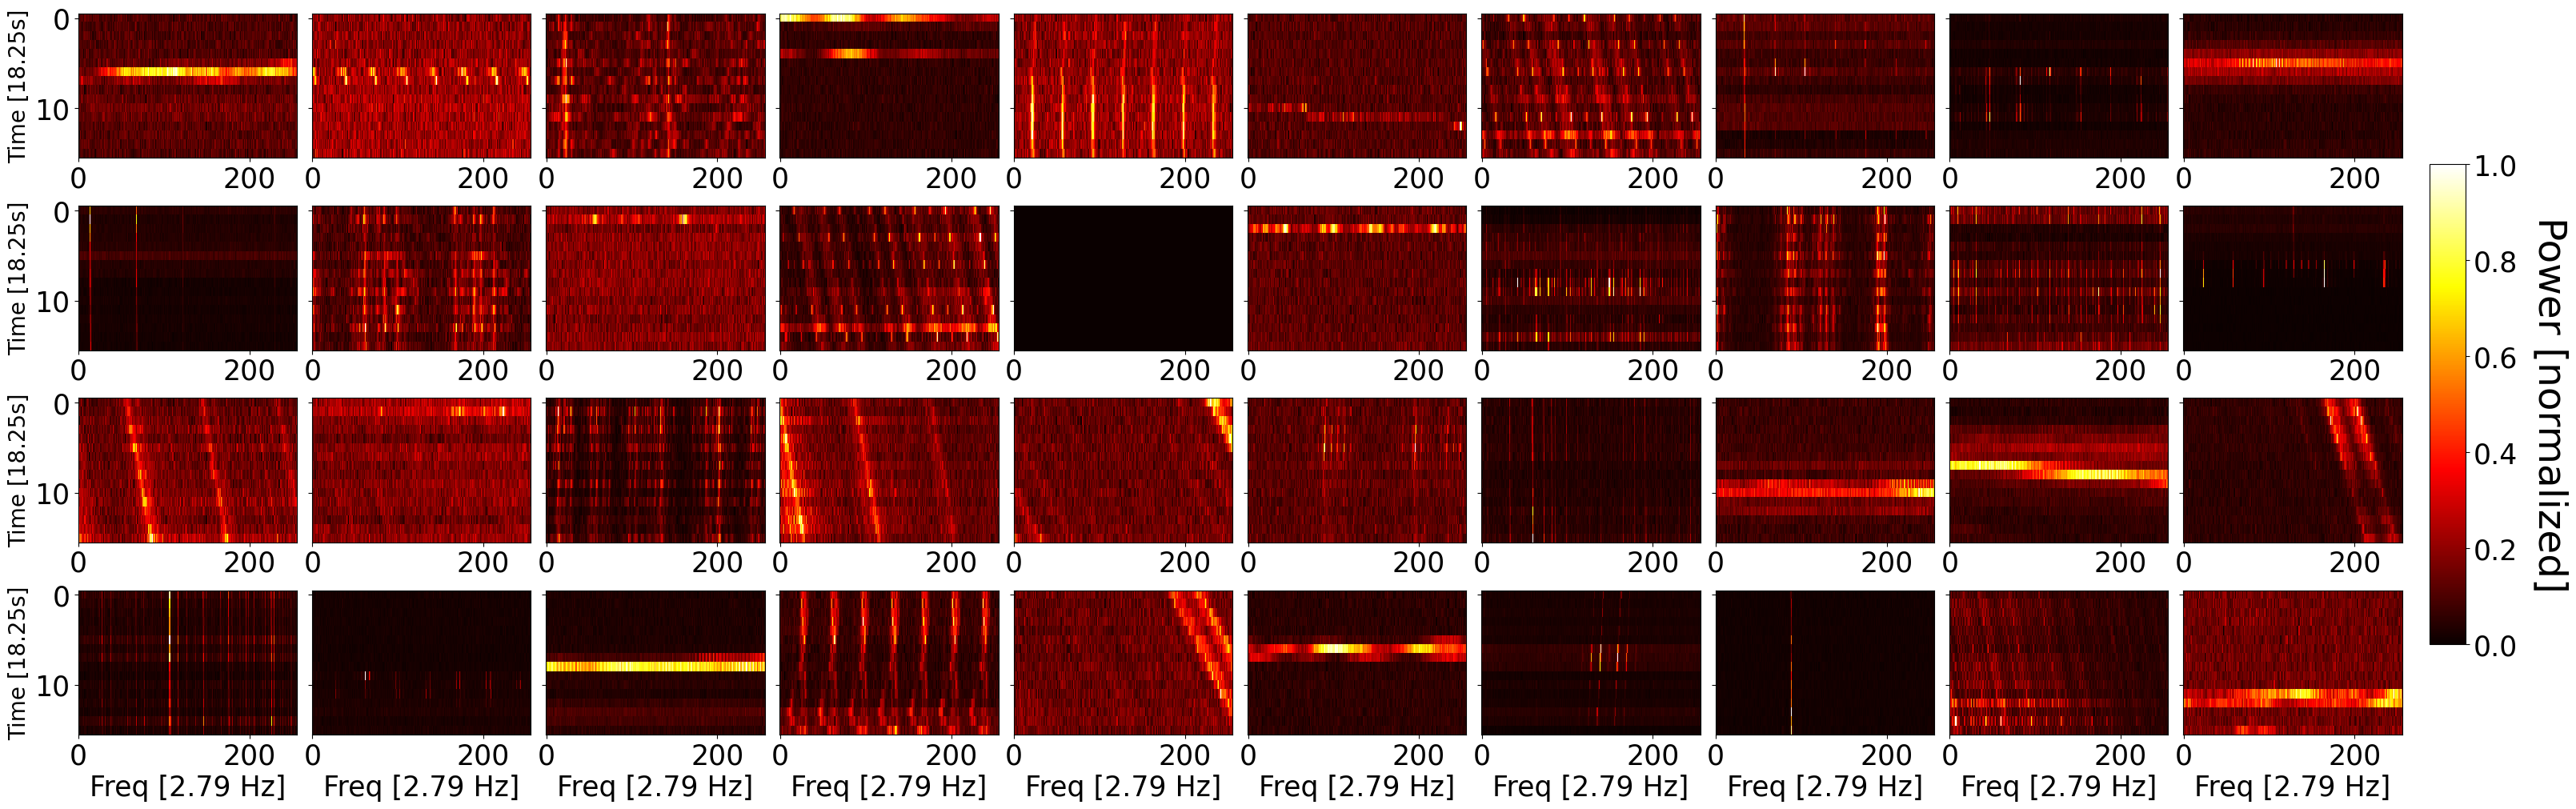

In [10]:
ind = np.random.randint(0, X_train.shape[0], size=(10, 10))
font_size = 25
plt.rcParams.update({'font.size': font_size})

f, ax = plt.subplots(4, 10, sharey=True, figsize=(30, 10), constrained_layout=True)

for j in range(10):
    for i in range(4):
        inde = ind[i, j]
        im = ax[i,j].imshow(X_train[inde,:,:,0], cmap='hot', interpolation='nearest', aspect="auto")
        if i == 3:
            ax[i,j].set_xlabel("Freq [2.79 Hz]",  fontsize=font_size)  
        if j ==0:
            ax[i,j].set_ylabel("Time [18.25s]",  fontsize=font_size-5)  
            
        
cbaxes = f.add_axes([1.01, 0.2, 0.015, 0.6]) 
cbar = f.colorbar(im, cax=cbaxes)
cbar.ax.tick_params(labelsize=font_size)
f.text(1.06, 0.5, 'Power [normalized]', ha='center', va='center', rotation=270, 
       fontsize=font_size+10)

plt.savefig("plots/training_examples.pdf", format="pdf")


# Encoder Model

In [11]:
latent_dim = 10
time_samples = X_train.shape[1]
freq_sample =  X_train.shape[2]
encoder_inputs = keras.Input(shape=(time_samples, freq_sample, 1))
x = layers.Conv2D(3, 3, activation="relu", strides=1, padding="same")(encoder_inputs)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x_shape = x.shape
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.BatchNormalization()(x)
z = layers.Dense(latent_dim, name="latent", activation="linear")(x)
encoder = keras.Model(encoder_inputs, z, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 256, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 16, 256, 3)        30        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 128, 3)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 128, 3)       12        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 128, 64)       1792      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 64, 64)       0   

2023-09-12 13:25:45.579682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 13:25:45.948560: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14233 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:a1:00.0, compute capability: 8.6


# Decoder Model

In [12]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(64, activation="relu")(latent_inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(x_shape[1]* x_shape[2]* x_shape[3], activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Reshape((x_shape[1], x_shape[2], x_shape[3]))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(3, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="linear", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_2 (Dense)             (None, 64)                704       
                                                                 
 dense_3 (Dense)             (None, 256)               16640     
                                                                 
 batch_normalization_7 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 8192)              2105344   
                                                                 
 batch_normalization_8 (Batc  (None, 8192)             32768     
 hNormalization)                                           

In [17]:
from AE import AE

def build_model(enocder, decoder):
    autoencoder = AE(encoder, decoder)
    autoencoder.compile(optimizer=keras.optimizers.Adam(lr=5e-4))
    return autoencoder

# Training Model

In [11]:
from keras.callbacks import EarlyStopping
from AE import AE
from keras.callbacks import CSVLogger
es = EarlyStopping(monitor='val_test_reconstruction_loss', mode='min', verbose=1, patience=10)
csv_logger = CSVLogger('log.csv', append=True, separator=',')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./checkpoints_file',
    save_weights_only=True,
    monitor='val_test_loss',
    mode='min',
    save_best_only=True)

autoencoder = build_model(encoder, decoder)

history = autoencoder.fit(X_train[:,:,:,:], validation_data = (X_test[:20_000,:,:,:],X_test[:20_000,:,:,:]),
                  epochs=200, batch_size = 128, callbacks=[es,csv_logger, model_checkpoint_callback])

Epoch 1/200


2023-07-02 06:47:12.237192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-07-02 06:47:14.256580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-02 06:47:15.039676: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fea90485fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-02 06:47:15.039764: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2023-07-02 06:47:15.045688: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-02 06:47:15.505655: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

3043/3043 [==============================] - 169s 51ms/step - loss: 21.0695 - reconstruction_loss: 16.6965 - val_test_loss: 14.2420 - val_test_reconstruction_loss: 14.2420 - val_clustering_loss: 0.6021
Epoch 2/200
3043/3043 [==============================] - 140s 46ms/step - loss: 13.8568 - reconstruction_loss: 13.5503 - val_test_loss: 13.0777 - val_test_reconstruction_loss: 13.0777 - val_clustering_loss: 0.5936
Epoch 3/200
3043/3043 [==============================] - 141s 46ms/step - loss: 12.8745 - reconstruction_loss: 12.7673 - val_test_loss: 12.6906 - val_test_reconstruction_loss: 12.6906 - val_clustering_loss: 0.5903
Epoch 4/200
3043/3043 [==============================] - 140s 46ms/step - loss: 12.4164 - reconstruction_loss: 12.3518 - val_test_loss: 12.2949 - val_test_reconstruction_loss: 12.2949 - val_clustering_loss: 0.5866
Epoch 5/200
3043/3043 [==============================] - 141s 46ms/step - loss: 12.1248 - reconstruction_loss: 12.0760 - val_test_loss: 12.1086 - val_test_r

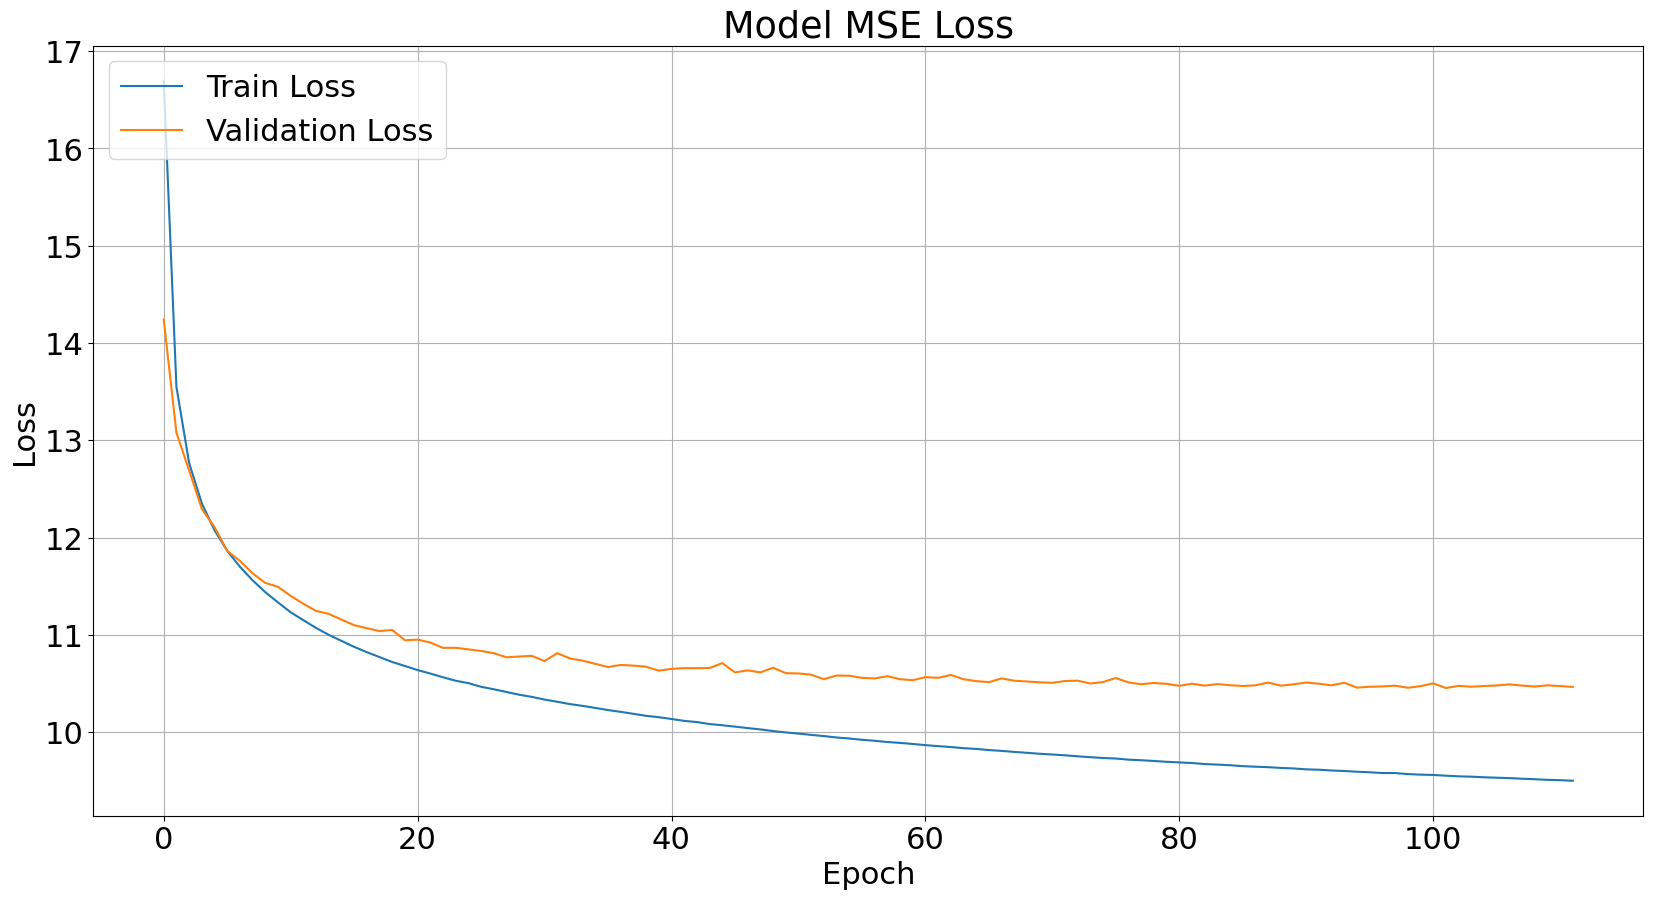

In [12]:
import pandas as pd
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
plt.plot(history.history['reconstruction_loss'])
plt.plot(history.history['val_test_reconstruction_loss'])
plt.title('Model MSE Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper left')
# plt.yscale('log')
plt.grid()
plt.savefig("plots/training_loss.pdf", format='pdf')
plt.show()

training_history = {}
training_history['train'] = history.history['reconstruction_loss']
training_history['test'] = history.history['val_test_reconstruction_loss']
df = pd.DataFrame(training_history)
df.to_csv("plots/training_loss.csv")

In [13]:
from datetime import datetime
now = datetime.now() # current date and time
date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
idtag = date_time.replace(', ','-').replace('/','-').replace(':','-')
print(idtag)

autoencoder.save_weights("models/full-weights-"+idtag, save_format="tf")

07-02-2023-11-08-47


In [18]:
# autoencoder.load_weights("models/full-weights-"+idtag)
autoencoder = build_model(encoder, decoder)

autoencoder.load_weights("models/full-weights-"+'07-02-2023-11-08-47')
autoencoder.compile(optimizer=keras.optimizers.Adam(lr = 1e-4), run_eagerly=True)

# Test Reconstruction

1/1 [==============================] - 0s 269ms/step
(1, 16, 256, 1)


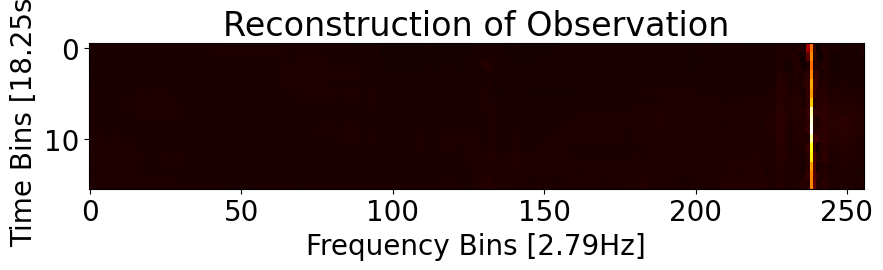

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 12

beam_reconstruction = autoencoder.decoder.predict(autoencoder.encoder.predict(X_test[index:index+1,:,:,:]))
print(beam_reconstruction.shape)

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10,5))
plt.title("Reconstruction of Observation")
plt.imshow(beam_reconstruction[0,:,:,0], cmap='hot', interpolation='nearest', aspect=3)
plt.ylabel("Time Bins [18.25s]")
plt.xlabel("Frequency Bins [2.79Hz]")
plt.savefig("plots/reconstruction.pdf", format='pdf')

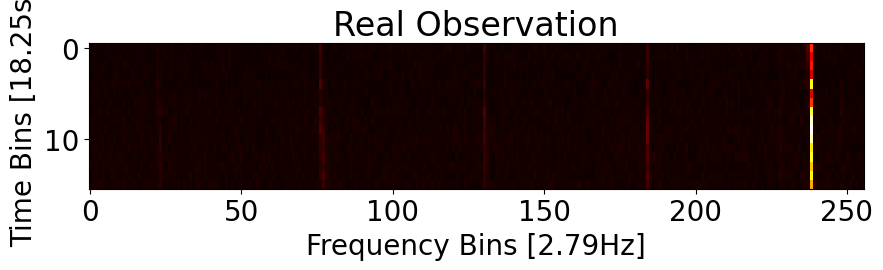

In [16]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10,5))
plt.title("Real Observation")
plt.imshow(X_test[index,:,:,0], cmap='hot', interpolation='nearest', aspect=3)
plt.ylabel("Time Bins [18.25s]")
plt.xlabel("Frequency Bins [2.79Hz]")
plt.savefig("plots/real.pdf", format='pdf')

1/1 [==============================] - 0s 12ms/step


Text(1.06, 0.5, 'Power [normalized]')

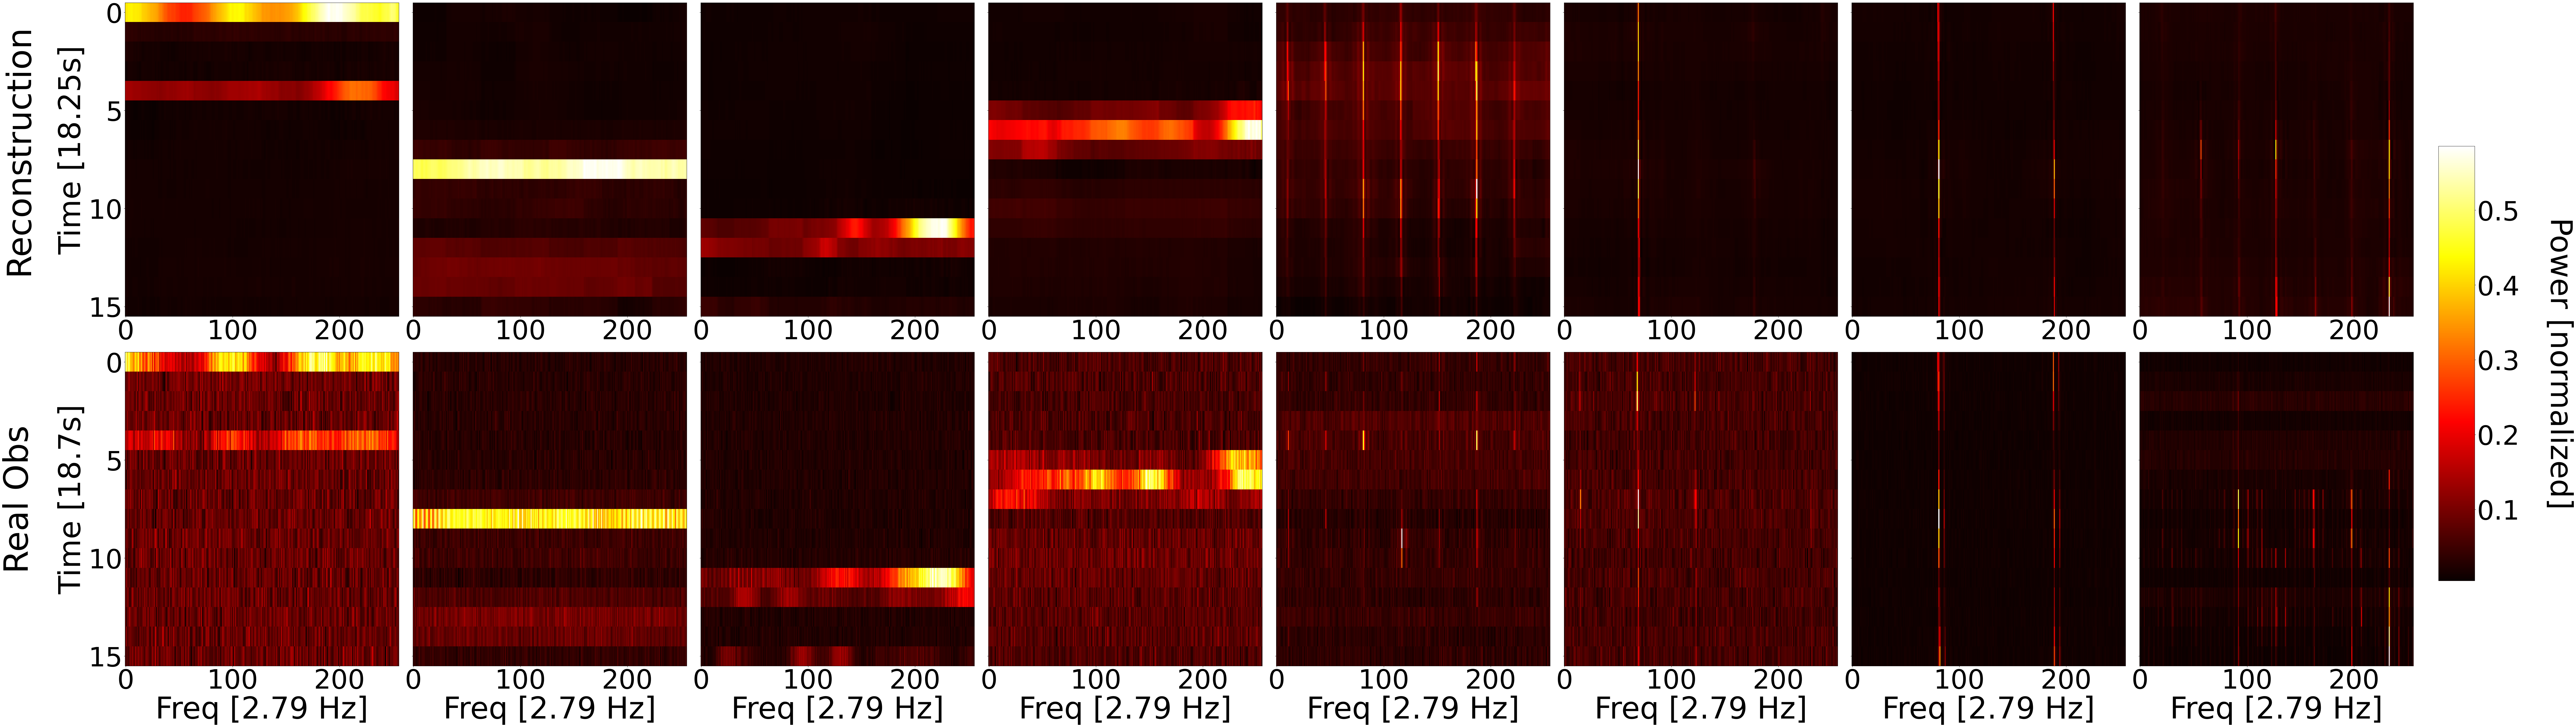

In [20]:
ind = np.random.randint(20_000, X_test.shape[0], size=(10))
font_size = 80
plt.rcParams.update({'font.size': font_size})

f, ax = plt.subplots(2, 8, sharey=True, figsize=(100, 30), constrained_layout=True)

for j in range(8):
    inde = ind[j]
    beam_reconstruction = autoencoder.decoder.predict(autoencoder.encoder.predict(X_test[inde:inde+1,:,:,:]))
    im = ax[0,j].imshow(beam_reconstruction[0,:,:,0], cmap='hot',
                        interpolation='nearest', aspect="auto")
    ax[1,j].imshow(X_test[inde,:,:,0], cmap='hot', interpolation='nearest', aspect="auto")
    if j == 0:
        ax[1,j].text(-50, 7, 'Time [18.7s]', ha='center', va='center', rotation='vertical',  fontsize=font_size+10)
        ax[1,j].text(-100, 7, 'Real Obs', ha='center', va='center', rotation='vertical', 
                     fontsize=font_size+20)
        ax[0,j].text(-100, 7, 'Reconstruction', ha='center', va='center', rotation='vertical',  fontsize=font_size  +20)
        ax[0,j].text(-50, 7, 'Time [18.25s]', ha='center', va='center', rotation='vertical',  fontsize=font_size+10)
    ax[1,j].set_xlabel("Freq [2.79 Hz]",  fontsize=font_size+10)  
    
cbaxes = f.add_axes([1.01, 0.2, 0.015, 0.6]) 
cbar = f.colorbar(im, cax=cbaxes)
cbar.ax.tick_params(labelsize=font_size)
f.text(1.06, 0.5, 'Power [normalized]', ha='center', va='center', rotation=270, 
       fontsize=font_size+10)

# plt.savefig("plots/reconstruction_test.pdf", format="pdf")